<a href="https://colab.research.google.com/github/Skaveza/HTML-CSS-contest_Group8/blob/main/Summative_Intro_to_ml_%5BSifa_Mwachoni%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [91]:
!pip install datasets

In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from typing import Tuple, Dict, Any
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


# The Dataset
> ***Brief Description:***

**Problem**: Displaced individuals often struggle to access quality healthcare, leaving them vulnerable in critical situations. This project aims to use data-driven insights to improve access to specialized medical care.

**Description**: The dataset includes over 6,000 healthcare facilities in Uganda, featuring key details such as facility name, services offered, location, rating, operating hours, contact info, care system, payment methods, and administrative region. This data helps predict healthcare facility ratings to enhance decision-making for vulnerable populations.


In [ ]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)

In [93]:
#Load dataset
import os
from huggingface_hub import login

# Fetch token from Colab secrets
hf_token = os.getenv("HF_TOKEN")
login(hf_token)

#Read dataset
df = pd.read_csv("hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv")

In [94]:
from datasets import load_dataset

def load_data(dataset_name: str):
    # Load dataset from Hugging Face
    dataset = load_dataset(dataset_name)
    return dataset

In [95]:
pd.set_option('display.max_columns', None)
df.head()

,facility_name,services,latitude,longitude,rating,operating_hours,website,phone_number,care_system,mode of payment,Subcounty
0,St. Francis Nyenga Hospital,"General Medical & Surgical Services, HIV/AIDS ...",0.379327,33.140027,3.5,"Monday: Open 24 hours,Tuesday: Open 24 hours,W...",NaN,NaN,PNFP,cash,Nyenga Division
1,Tongolo HC II,General Care,0.373296,33.100767,NaN,"N,/,A",NaN,0772 971109,GOVT,cash,Nyenga Division
2,Kasubi HC III,"Imaging Services, OPD, Specialized Clinics",0.327001,32.552565,NaN,"Monday: Open 24 hours,Tuesday: Open 24 hours,W...",NaN,0706 399074,GOVT,cash,Buikwe Subcounty
3,Buikwe HC III,"Maternal and Child Health, Outpatient, Inpatie...",0.344226,33.026341,NaN,"Monday: 8:00â€¯AMâ€‰â€“â€‰5:00â€¯PM,Tuesday: 8...",NaN,0782 014778,GOVT,cash,Buikwe Town Council
4,Buikwe St. Charles Lwanga Hospital,"General Medical & Surgical Services, HIV/AIDS ...",0.339290,33.032193,4.7,"Monday: Open 24 hours,Tuesday: Open 24 hours,W...",NaN,0774 342186,PNFP,cash,Buikwe Town Council


In [96]:
#Data pre-processing
#Validation
def validate_and_preprocess(data, text_max_features=100):
    """
    Validate and preprocess data, handling missing values and encoding.
    """
    try:
        # Convert input to DataFrame if dictionary
        if isinstance(data, dict):
            df = pd.DataFrame(data.get('train', data))
        else:
            df = data.copy()

        # Validate required columns
        required_columns = ['rating', 'services', 'operating_hours']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Handle ratings (convert to numeric, fill missing values)
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
        rating_mean = df['rating'].mean()
        df['rating'] = df['rating'].fillna(rating_mean)

        return df, rating_mean

    except Exception as e:
        raise Exception(f"Error in validation: {str(e)}")
validated_data, rating_mean = validate_and_preprocess(df)

print(validated_data.head())

                        facility_name  \
0         St. Francis Nyenga Hospital   
1                       Tongolo HC II   
2                       Kasubi HC III   
3                       Buikwe HC III   
4  Buikwe St. Charles Lwanga Hospital   

                                            services  latitude  longitude  \
0  General Medical & Surgical Services, HIV/AIDS ...  0.379327  33.140027   
1                                       General Care  0.373296  33.100767   
2         Imaging Services, OPD, Specialized Clinics  0.327001  32.552565   
3  Maternal and Child Health, Outpatient, Inpatie...  0.344226  33.026341   
4  General Medical & Surgical Services, HIV/AIDS ...  0.339290  33.032193   

     rating                                    operating_hours website  \
0  3.500000  Monday: Open 24 hours,Tuesday: Open 24 hours,W...     NaN   
1  3.987208                                              N,/,A     NaN   
2  3.987208  Monday: Open 24 hours,Tuesday: Open 24 hours,W...     N

In [97]:
def prepare_training_data(df, text_max_features=100):
    """
    Extract features, encode categorical data, and apply SMOTE for balancing.
    """
    try:
        # Categorize ratings into 'low', 'medium', 'high'
        num_categories = 3
        df['rating_category'] = pd.qcut(
            df['rating'],
            q=num_categories,
            labels=['low', 'medium', 'high'],
            duplicates='drop'
        )

        # Process categorical features
        categorical_columns = ['care_system', 'mode of payment', 'Subcounty']
        categorical_encoded = pd.get_dummies(df[categorical_columns], dummy_na=True)

        # Process numerical features
        numerical_columns = ['latitude', 'longitude']
        numerical_data = df[numerical_columns].fillna(0)

        # Process text features
        text_features = ['services', 'operating_hours']
        text_processors = {}
        text_features_combined = pd.DataFrame()

        for feature in text_features:
            if feature in df.columns:
                tfidf = TfidfVectorizer(max_features=text_max_features, stop_words='english', lowercase=True)
                text_data = df[feature].fillna('')
                text_features_matrix = tfidf.fit_transform(text_data)
                feature_names = [f"{feature}_{i}" for i in range(text_features_matrix.shape[1])]
                text_features_combined = pd.concat([
                    text_features_combined,
                    pd.DataFrame(text_features_matrix.toarray(), columns=feature_names)
                ], axis=1)
                text_processors[feature] = tfidf

        # Combine all features (Numerical + Categorical + Text)
        X = pd.concat([numerical_data, categorical_encoded, text_features_combined], axis=1)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(df['rating_category'])
        y_cat = to_categorical(y_encoded)

        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)
        y_resampled_cat = to_categorical(y_resampled)

        return {
            'X_scaled': X_resampled,
            'y_cat': y_resampled_cat,
            'label_encoder': label_encoder,
            'scaler': scaler,
            'text_processors': text_processors
        }

    except Exception as e:
        raise Exception(f"Error in training data preparation: {str(e)}")


In [98]:
# Training: Data Splitting Function
from sklearn.model_selection import train_test_split

def prepare_data_splits(X, y, test_size=0.2, validation_size=0.2):
    """
    Split data into train, validation, and test sets
    """
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,
        stratify=y.argmax(axis=1)
    )

    val_size = validation_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size,
        random_state=42,
        stratify=y_temp.argmax(axis=1)
    )

    return {
        'train': (X_train, y_train),
        'validation': (X_val, y_val),
        'test': (X_test, y_test)
    }
    # Execution: Running the Preprocessing and Splitting
if __name__ == "__main__":
    try:
        # Preprocess the data
        validated_data, rating_mean = validate_and_preprocess(df)  # Unpacking the tuple correctly

        # Extract features (Call prepare_training_data)
        preprocessed_data = prepare_training_data(validated_data)  # return a dictionary

        print(type(preprocessed_data))  # Debugging: Check what preprocessed_data is

        # Split the data
        splits = prepare_data_splits(
            preprocessed_data['X_scaled'],  #Access dictionary keys properly
            preprocessed_data['y_cat']
        )

        print("Data preprocessing completed successfully!")
        print(f"Training set size: {splits['train'][0].shape[0]}")
        print(f"Validation set size: {splits['validation'][0].shape[0]}")
        print(f"Test set size: {splits['test'][0].shape[0]}")

    except Exception as e:
        print(f"Error occurred: {str(e)}")


<class 'dict'>
Data preprocessing completed successfully!
Training set size: 6981
Validation set size: 2328
Test set size: 2328


In [99]:
# Assuming 'splits' dictionary exists and contains training data
input_shape = (splits['train'][0].shape[1],)  # Access X_train from splits dictionary       # Assuming create_all_models function is defined elsewhere

# Model Architecture

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


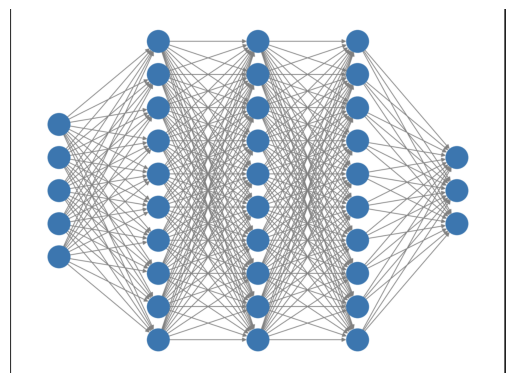

In [13]:
import matplotlib.pyplot as plt
import cv2

img_path = "/content/Screenshot 2025-02-22 at 14.04.13.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

#Task: Define a function that creates models without and With specified Optimization techniques


In [100]:
def create_base_nn(input_shape, num_classes=3, dropout=0.0, learning_rate=0.001, early_stopping=False):
    """
    Create basic neural network without optimization techniques

    Parameters:
    input_shape: tuple, shape of input features
    num_classes: int, number of output classes
    dropout: float, dropout rate for regularization (default: 0.0)
    learning_rate: float, learning rate for the optimizer (default: 0.001)
    early_stopping: bool, whether to include early stopping callback (default: False)

    Returns:
    model: compiled Keras model
    callbacks: list of callbacks (if early stopping is enabled)
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model with the specified learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Use Adam optimizer
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = []
    if early_stopping:
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks.append(early_stopping_callback)

    return model, callbacks



In [101]:
# Create model with dropout and learning rate settings
model, callbacks = create_base_nn(
    input_shape=(splits['train'][0].shape[1],),
    dropout=0.2,
    learning_rate=0.001,
    early_stopping=True
)

# Training the model
history_base_nn = model.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=10,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks if callbacks else None
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4539 - loss: 1.0615 - val_accuracy: 0.5906 - val_loss: 0.8618
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6915 - loss: 0.7305 - val_accuracy: 0.6383 - val_loss: 0.8075
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7442 - loss: 0.5944 - val_accuracy: 0.6576 - val_loss: 0.8249
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7782 - loss: 0.5244 - val_accuracy: 0.6727 - val_loss: 0.8154
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8005 - loss: 0.4680 - val_accuracy: 0.6714 - val_loss: 0.8742


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [102]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(splits['test'][0], splits['test'][1])  # Access X_test, y_test from splits

# Print out the accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6624 - loss: 0.7771
Test Accuracy: 65.98%


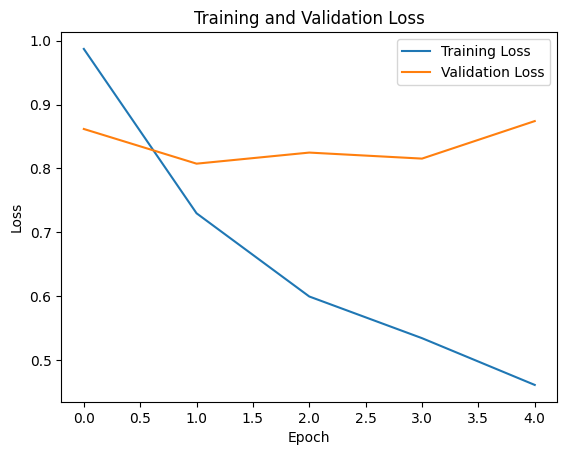

In [105]:
plt.plot(history_base_nn.history['loss'], label='Training Loss')
plt.plot(history_base_nn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
# 3. Generate Classification Report
y_pred = model.predict(splits['test'][0]) # Changed base_nn to model
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true_classes = np.argmax(splits['test'][1], axis=1)  # Convert true labels to class labels

print(classification_report(y_true_classes, y_pred_classes))

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       776
           1       0.67      0.56      0.61       776
           2       0.71      0.85      0.77       776

    accuracy                           0.66      2328
   macro avg       0.66      0.66      0.65      2328
weighted avg       0.66      0.66      0.65      2328



# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [109]:
#Neural Model 2
def create_optimized_nn1_fixed(input_shape, num_classes=3, l1_lambda=0.01):
    """
    Optimized Neural Network with L1 Regularization, Dropout, and Batch Normalization
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile Model with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, [reduce_lr, early_stopping]



In [110]:
# Call the function to create the model
model_optimized_nn1_fixed, callbacks = create_optimized_nn1_fixed(input_shape=(splits['train'][0].shape[1],), l1_lambda=0.01)

# Train the model
history_fixed = model_optimized_nn1_fixed.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=40,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3784 - loss: 65.4853 - val_accuracy: 0.3406 - val_loss: 16.8220 - learning_rate: 0.0010
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4741 - loss: 13.5306 - val_accuracy: 0.3741 - val_loss: 8.2815 - learning_rate: 0.0010
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4906 - loss: 7.7883 - val_accuracy: 0.4704 - val_loss: 6.3065 - learning_rate: 0.0010
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5122 - loss: 5.9424 - val_accuracy: 0.5021 - val_loss: 5.2500 - learning_rate: 0.0010
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5203 - loss: 5.0277 - val_accuracy: 0.5112 - val_loss: 4.4676 - learning_rate: 0.0010
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5334 - loss: 4.3407 - val_accuracy: 0.5326 - val_loss: 4.2426 - learning_rate: 0.0010
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5355 - loss:

In [111]:
#Model Accuracy
test_loss, test_accuracy = model_optimized_nn1_fixed.evaluate(splits['test'][0], splits['test'][1])
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6269 - loss: 1.2553
Test Accuracy: 63.23%


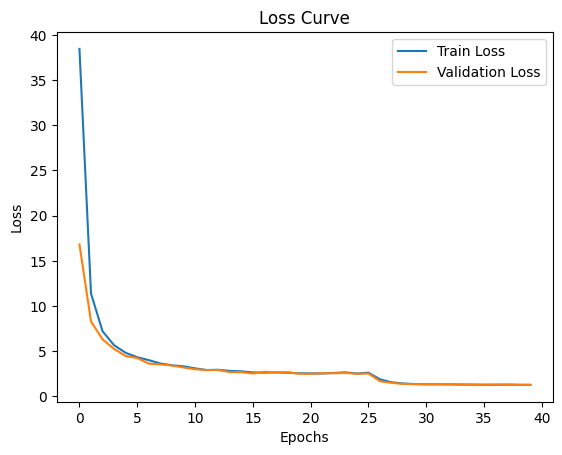

In [113]:
#Loss curve
plt.plot(history_fixed.history['loss'], label='Train Loss') # Changed history_optimized to history_fixed
plt.plot(history_fixed.history['val_loss'], label='Validation Loss') # Changed history_optimized_nn1 to history_fixed
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.57       776
           1       0.69      0.52      0.59       776
           2       0.68      0.78      0.73       776

    accuracy                           0.63      2328
   macro avg       0.64      0.63      0.63      2328
weighted avg       0.64      0.63      0.63      2328



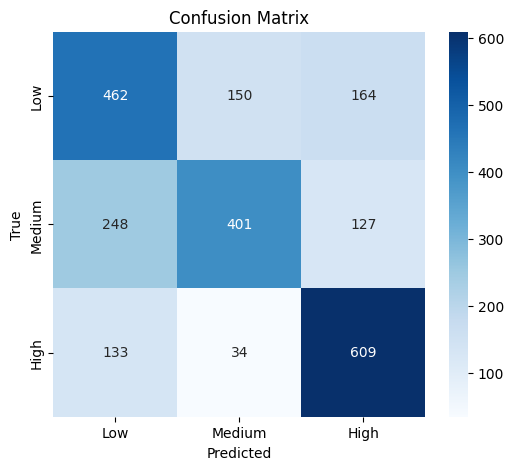

In [115]:
#Classification Report and Confusion Matrix
# Predict classes
y_pred_probs = model_optimized_nn1_fixed.predict(splits['test'][0])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(splits['test'][1], axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [118]:
#Neural Network 3
def create_optimized_nn2(input_shape, num_classes=3):
    """
    Create an optimized neural network with class weighting, L1-L2 regularization, and fine-tuned dropout.

    Parameters:
    input_shape: tuple, shape of input features
    num_classes: int, number of output classes

    Returns:
    model: compiled Keras model
    callbacks: list of callbacks for training
    """

    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    # Learning rate reduction
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate for stability
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [reduce_lr, early_stopping]

    return model, callbacks

# Compute class weights
def get_class_weights(y_resampled):
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_resampled),
        y=y_resampled
    )
    return dict(enumerate(class_weights))


In [133]:
# Call function to create model
input_shape = (preprocessed_data['X_scaled'].shape[1],)
model, callbacks = create_optimized_nn2(input_shape)

# Compute class weights for training
class_weights = get_class_weights(preprocessed_data['y_cat'].argmax(axis=1))

# Train the model
history_nn2 = model.fit(
    preprocessed_data['X_scaled'], preprocessed_data['y_cat'],
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4372 - loss: 9.5589 - val_accuracy: 0.0000e+00 - val_loss: 4.5595 - learning_rate: 5.0000e-04
Epoch 2/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5348 - loss: 3.5491 - val_accuracy: 0.0000e+00 - val_loss: 3.0494 - learning_rate: 5.0000e-04
Epoch 3/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5748 - loss: 2.1779 - val_accuracy: 0.0000e+00 - val_loss: 2.2110 - learning_rate: 5.0000e-04
Epoch 4/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5876 - loss: 1.5816 - val_accuracy: 0.0000e+00 - val_loss: 1.8788 - learning_rate: 5.0000e-04
Epoch 5/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5979 - loss: 1.3272 - val_accuracy: 0.0000e+00 - val_loss: 1.7774 - learning_rate: 5.0000e-04
Epoch 6/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5987 - loss: 1.2024 - val_accuracy: 0.0000e+00 - val_loss: 1.6554 - learning_rate: 5.0000e-04
Epoch 7/100
291/291 ━━━━━━━━

In [134]:
#Model Accuracy
test_loss, test_accuracy = model.evaluate(splits['test'][0], splits['test'][1], verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8430 - loss: 0.7033
Test Accuracy: 84.02%


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81       776
           1       0.94      0.78      0.85       776
           2       0.89      0.85      0.87       776

    accuracy                           0.84      2328
   macro avg       0.85      0.84      0.84      2328
weighted avg       0.85      0.84      0.84      2328



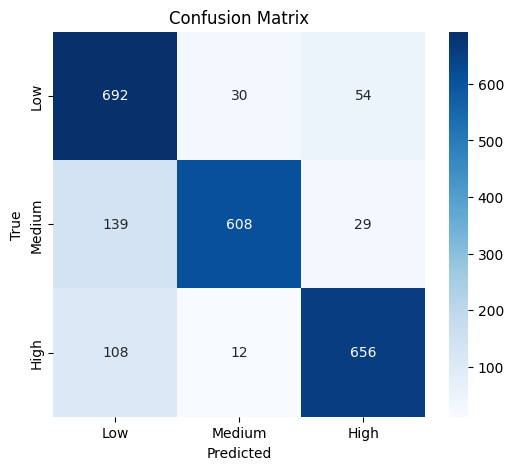

In [136]:
#Classification Report and Confusion Matrix
# Predict classes
y_pred_probs = model.predict(splits['test'][0])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(splits['test'][1], axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

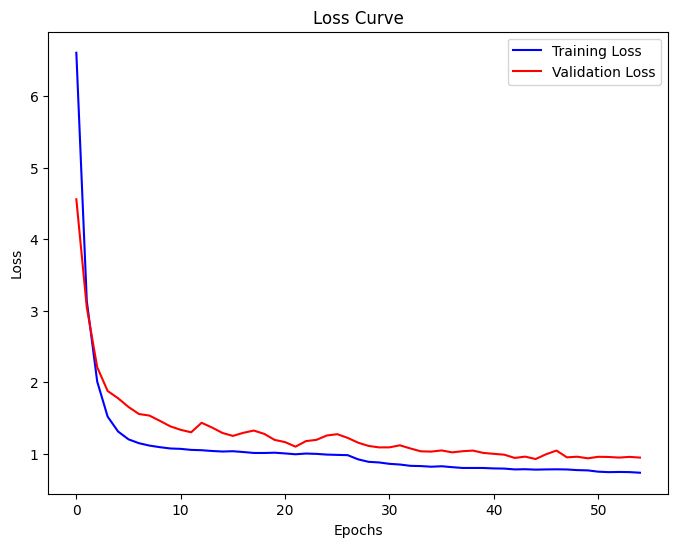

In [135]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history_nn2.history['loss'], label='Training Loss', color='blue')
plt.plot(history_nn2.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


In [138]:
def create_rf_classifier():
    """
    Create and return a Random Forest Classifier with balanced class weights.

    Returns:
    model: Random Forest Classifier
    """
    return RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
X_train, y_train = splits['train']

rf_model = create_rf_classifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [140]:
#Model Accuracy And Classification Report
#Model Accuracy
rf_model = create_rf_classifier()
rf_model.fit(X_train, y_train)

# Extract X_test and y_test from the splits dictionary
X_test, y_test = splits['test']

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 73.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.73       776
           1       0.84      0.73      0.78       776
           2       0.89      0.83      0.86       776

   micro avg       0.86      0.74      0.79      2328
   macro avg       0.85      0.74      0.79      2328
weighted avg       0.85      0.74      0.79      2328
 samples avg       0.74      0.74      0.74      2328



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


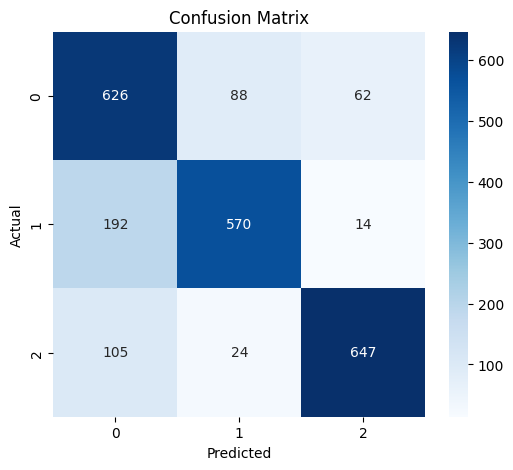

In [142]:
# Plot Confusion Matrix
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes)) # Update labels for heatmap
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(None)
    # Make predictions
    predictions = None
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [ ]:
model_path = None
make_predictions(None)

Congratulations!!
